# Install detectron2

In [ ]:
### it may be necessary to restart the kernel after installation (for whatever reason)
import sys
!{sys.executable} -m pip install --upgrade pip
import torch, torchvision
if torch.version.cuda == '10.0.130':
    !{sys.executable} -m pip install --upgrade pip
    !{sys.executable} -m pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
    !{sys.executable} -m pip install cython pyyaml==5.1
    !{sys.executable} -m pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
    !{sys.executable} -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
elif torch.version.cuda == '10.1':
    !{sys.executable} -m pip install cython 
    !{sys.executable} -m pip install pyyaml
    !{sys.executable} -m pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
    !{sys.executable} -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html
else:
    print(torch.version.cuda)

# Imports

In [47]:
#import sys
#sys.path.append('/opt/conda/lib/python3.7/site-packages')
#sys.path.append('/opt/conda/envs/DLM_R2Py/lib/python3.7/site-packages')

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

%reload_ext autoreload
%autoreload 2
import sys
#!{sys.executable} -m pip install --upgrade matplotlib
#%matplotlib notebook
%matplotlib inline
#from bokeh.io import output_notebook

from typing import Dict, List, Callable, Tuple, Union


sys.path.append('../wsi_processing_pipeline/')
sys.path.append('../wsi_processing_pipeline/tile_extraction/')
from tile_extraction import tiles, util, slide


import os
import pandas
import pandas as pd
import numpy
import numpy as np
import torch, torchvision
import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]

import PIL
from PIL import Image

import fastai
from fastai import vision
import matplotlib.pyplot as plt
import matplotlib.patches
import pycocotools
#from pycocotools import mask
from itertools import groupby
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import cv2
import random
import scipy.io
import json
import pickle
import math
import multiprocessing

#Base path to datasets
PATH = Path('/home/Deep_Learner/private/datasets/nuclei_datasets/')


dataset_name_train = 'nuclei_train'
dataset_name_valid = 'nuclei_valid'
dataset_name_test = 'nuclei_test'
dataset_name_all_combined = 'all_combined'
dataset_name_all_combined_without_excluded = 'all_combined_without_excluded'

seed = 19
np.random.seed(seed)

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import ColorMode

# util functions  // TODO: function from polygon representation to binary mask

In [2]:
def visualize(dataset_dicts:List[Dict],
              metadata:detectron2.data.catalog.Metadata,
              ground_truth_available:bool,
              with_preds:bool,
              predictor, 
              extract_otf_from_wsi:bool=False, 
              captions:List[str] = None, 
              figsize=(20,20), 
              caption_generators:List[Callable]=None):
    """
    Arguments:
        caption_generators: every caption_generator is a function that takes a dict from the dataset_dicts list and returns
                            some value, which will be printed together with the function name over the image
    """
    for n, d in enumerate(dataset_dicts):
        path = d['file_name']
        print(path)
                
        imgs_to_show = []
               
        ### original image
        img = None
        if not extract_otf_from_wsi:
            ###some of the images are in rgba format, [:,:,:3] drops the alpha
            img = numpy.array(PIL.Image.open(path))[:,:,:3]
        else:
            img = numpy.array(open_image_from_wsi(d))           
        imgs_to_show.append(img)
        
        ### instantiate Visualizer
        v = Visualizer(img,
                       metadata=metadata, 
                       scale=1, 
                       instance_mode=ColorMode.IMAGE)
        
        ### prediction
        if with_preds:
            pred = predictor(img[:, :, ::-1])
            n_predicted = len(pred['instances'])
            print(f'number of predicted instances: {n_predicted}')
            img_with_preds = v.draw_instance_predictions(pred["instances"].to("cpu")).get_image()
            imgs_to_show.append(img_with_preds)
            
                                
        ### ground truth
        if ground_truth_available:
            ### image with ground truth boxes and masks   
            img_with_ground_truth = v.draw_dataset_dict(d).get_image()
            imgs_to_show.append(img_with_ground_truth)
            
            ##  // TODO: function from polygon representation to binary mask
            ### merged masks of the ground truth
            #masks = None
            #try:
            #    masks = [open_mask_as_np(mp) for mp in get_masks_path_from_id(path.stem, base_path=path.parent.parent.parent).ls()]    
            #except FileNotFoundError:
            #    masks = get_mask_list_from_rle_for_one_id(path.stem, df_rle_labels, shape=(d['width'],d['height']))
            #n_actual = d['annotations']
            #print(f'number of actual instances: {len(n_actual)}')
            #print(f'number of actual instances: {len(masks)}')
            #merged_mask_ground_truth = merge_masks(masks, shape=(masks[0].shape[0], masks[0].shape[1]))
            #imgs_to_show.append(merged_mask_ground_truth)
            
        
        ### captions
        try:
            print(captions[n])
        except:
            ## do nothing
            pass
        
        if caption_generators != None and len(caption_generators) > 0:
            for cg in caption_generators:
                try:
                    print(f'{cg.__name__}: {cg(d)}')
                except:
                    print(f'{cg.__name__}: failed')
               
        ### plot    
        f, axarr = plt.subplots(1,len(imgs_to_show), figsize=figsize)
        for n, i in enumerate(imgs_to_show):
            if len(i.shape) == 2:
                axarr[n].imshow(i)
            else:
                axarr[n].imshow(i)            
        plt.show()


def get_all_file_paths_recursively(path:pathlib.Path, suffix:str = '.png')->List[pathlib.Path]:
    paths = []
    for p in path.ls():
        if p.is_file() and p.suffix == suffix:
            paths.append(p)
        elif p.is_dir():
            paths = paths + get_all_file_paths_recursively(p)
    return paths 

def save_as_pickle(obj:object, path):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)

def load_pickle(path):
    with open(path, 'rb') as file:
        return pickle.load(file)


def save_as_json(dataset_dict, path):
    with open(path, 'w') as outfile:
        json.dump(dataset_dict, outfile)

def load_json(path)->List[Dict]:
    with open(path) as json_file:
        #return json.loads(json.load(json_file))
        return json.load(json_file)


    
from matplotlib.pyplot import imshow
def show_pil(path:pathlib.Path):    
    imshow(np.asarray(Image.open(path)))
    plt.show()

def get_path_from_id(img_id:str, base_path:pathlib.Path)->pathlib.Path:
    """
    Arguments:
        base_path: here ~/2018_Data_Science_Bowl/stage1_train/   or   ~/2018_Data_Science_Bowl/stage1_test/
    """
    for p in base_path.ls():
        if img_id in p.stem:
            return p

def get_masks_path_from_id(img_id:str, base_path:pathlib.Path)->pathlib.Path:
    """
    Arguments:
        base_path: here ~/2018_Data_Science_Bowl/stage1_train/   or   ~/2018_Data_Science_Bowl/stage1_test/
    """
    return get_path_from_id(img_id, base_path)/'masks'
        
def open_mask_as_np(path:pathlib.Path)->numpy.ndarray:
    return np.asarray(PIL.Image.open(path), dtype=np.bool)


def show_np(arr:numpy.ndarray, figsize:tuple=(4,4)):
    #plt.imshow(arr)
    #plt.show()
    f, axarr = plt.subplots(1,1, figsize=figsize)
    axarr.imshow(arr)            
    plt.show()

def show_np_with_bboxes(img:numpy.ndarray, bboxes:List[numpy.ndarray], figsize:tuple=(10,10)):
    """
    Arguments:
        img: img as numpy array
        bboxes: List of bounding boxes where each bbox is a numpy array: 
                array([ x-upper-left, y-upper-left,  width,  height]) 
                e.g. array([ 50., 211.,  17.,  19.])
    """    
    # Create figure and axes
    fig,ax = plt.subplots(1,1,figsize=figsize)    
    # Display the image
    ax.imshow(img)    
    # Create a Rectangle patch for each bbox
    for b in bboxes:
        rect = matplotlib.patches.Rectangle((b[0],b[1]),b[2],b[3],linewidth=1,edgecolor='r',facecolor='none')    
        # Add the patch to the Axes
        ax.add_patch(rect)    
    plt.show() 
  
    
def merged_mask_to_list_of_single_masks(merged_mask:numpy.array, 
                                        noise_removal:bool=False, 
                                        distance_transform_threshold:float=0.0 )->List[numpy.array]:
    """
    techniques from here:
    https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_watershed/py_watershed.html
    
        Arguments:
           merged_mask: a binary mask as numpy array with shape (height, width), no third dimension
           noise_removal: if True, small noise will be removed
           distance_transform_threshold: between 0.0 and 1.0, the larger the more "shrinking" will be applied to seperate
                                           touching objects via distance transformation
        Result:
            List of binary mask for every single instance
    """
    # noise removal
    if noise_removal:
        kernel = np.ones((3,3),np.uint8)
        merged_mask = cv2.morphologyEx(merged_mask,cv2.MORPH_OPEN,kernel, iterations = 2)
    
    # separate touching objects via shrinking
    if distance_transform_threshold > 0.0:
        merged_mask = cv2.distanceTransform(merged_mask,cv2.DIST_L2,5)
        ret, merged_mask = cv2.threshold(merged_mask,distance_transform_threshold*merged_mask.max(),255,0)
        merged_mask = merged_mask.astype(np.uint8)

    ret, markers = cv2.connectedComponents(merged_mask)
    return [(markers == n).astype(int) for n in range(1, ret)]

    
    
def merge_masks(masks:List[numpy.ndarray], shape:tuple=(256,256))->numpy.ndarray:
    merged_mask = np.zeros((shape[0],shape[1]), dtype=np.bool)
    for mask in masks:
        merged_mask = np.maximum(merged_mask, mask)
    return merged_mask

def merge_masks_from_path(path:pathlib.Path, shape:tuple=(256,256))->numpy.ndarray:
    return merge_masks([open_mask_as_np(p) for p in path.ls()], shape)


def rle_encode(mask_np:numpy.ndarray)->List[int]:
    '''
    mask_np: numpy array of shape (height, width), 1 = mask, 0 = background
    Returns run length as list
    '''
    dots = np.where(mask_np.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def rle_from_list_to_string(rle_as_list:List[int])->str:
    return ' '.join([str(e) for e in rle_as_list])

def rle_decode(mask_rle:str, shape:tuple=(256, 256))->numpy.ndarray:
    '''
    Arguments:
        mask_rle: run-length as string formated (start length) e.g. "6908 1 7161 8 7417 8"
        shape: (height,width) of array to return
    Returns: 
        numpy array, True == mask, False == background
    '''
    #print('rle_decode(mask_rle = ', mask_rle)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    mask = np.zeros(shape[0]*shape[1], dtype=np.bool)
    for lo, hi in zip(starts, ends):
        mask[lo:hi] = True
    # Needed to align to RLE direction
    return mask.reshape(shape).T

def get_mask_list_from_rle_for_one_id(img_id:str, 
                                      df:pandas.DataFrame, 
                                      coloumn_name_ids:str='ImageId',
                                      coloumn_name_rle:str='EncodedPixels',
                                      shape:tuple=(256,256))->List[numpy.ndarray]:
    """
    Arguments:
        shape: tuple (width, height)
    Returns:
        
    """
    masks_rle_df = df.loc[df[coloumn_name_ids] == img_id]
    masks = []
    for index, row in masks_rle_df.iterrows():
        #print(row[coloumn_name_rle])
        masks.append(rle_decode(row[coloumn_name_rle], shape))
    return masks

def mask_to_bbox(mask_np:numpy.ndarray)->numpy.ndarray:
    """
    Arguments: 
        mask_np: binary mask as numpy array where mask == True or 1 or 1.0 and background == False or 0 or 0.0
    Returns:
        bounding box as numpy array: array([ x-upper-left, y-upper-left,  width,  height]) 
                                        e.g. array([ 50., 211.,  17.,  19.])
    """
    return pycocotools.mask.toBbox(pycocotools.mask.encode(np.asarray(mask_np, order="F")))


def rle_encode_pycoco(mask_np:numpy.ndarray)->dict:
    '''
    Arguments:
        mask_np: numpy array of shape (height, width), 1 = mask, 0 = background
    Returns: 
        dict with size and per-pixel segmentation mask in COCO's RLE format.        
    '''
    #option 1
    return pycocotools.mask.encode(np.asarray(mask, order="F"))
    #option 2
    #rle = {'counts': [], 'size': list(mask_np.shape)}
    #counts = rle.get('counts')
    #for i, (value, elements) in enumerate(groupby(mask_np.ravel(order='F'))):
    #    if i == 0 and value == 1:
    #        counts.append(0)
    #    counts.append(len(list(elements)))
    #return rle

#!{sys.executable} -m pip install imantics
import imantics
from imantics import Polygons, Mask
def get_polygon_from_binary_mask(mask_np:numpy.ndarray)->List[float]:
    """
    Arguments:
        binary mask as numpy array
    Returns:
        list[int] is one simple polygon in the format of [x1, y1, ..., xn, yn]
    """
    return [float(c) for c in list(Mask(mask_np).polygons()[0])]

# some util examples

## load csv

In [ ]:
s1_trn_lbs_df = pd.read_csv(STAGE1_TRAIN_LABELS)

In [ ]:
s1_trn_lbs_df

In [ ]:
img_id = s1_trn_lbs_df.iloc[0][0];img_id

## merge existing single masks of one image - example

In [ ]:
img_id_p = get_path_from_id(img_id, STAGE1_TRAIN)

In [ ]:
masks_path = get_masks_path_from_id(img_id, STAGE1_TRAIN);masks_path

In [ ]:
masks_np = [open_mask_as_np(p) for p in masks_path.ls()]

In [ ]:
merged_mask = merge_masks_from_path(masks_path,(256,256))

In [ ]:
show_np(merged_mask)

## decode run length encoding to mask - example

In [ ]:
masks = get_mask_list_from_rle_for_one_id(img_id, s1_trn_lbs_df)

In [ ]:
merged_mask = merge_masks(masks)

In [ ]:
show_np(merged_mask)

## get bounding box from mask in format x,y (left upper corner); width, heigth - example

In [ ]:
img_id

In [ ]:
img_p = get_path_from_id(img_id, STAGE1_TRAIN);img_p

In [ ]:
masks_p = get_masks_path_from_id(img_id, STAGE1_TRAIN);masks_p

In [ ]:
bboxes = []
for p in masks_p.ls():
    mask_np = open_mask_as_np(p)
    bboxes.append(mask_to_bbox(mask_np))

In [ ]:
merged_mask = merge_masks_from_path(masks_p)

In [ ]:
show_np_with_bboxes(merged_mask,bboxes)

# Data

## Get various datsets into right format for detectron2

### dsb 2018

In [ ]:
#data science bowl 2018 dataset
DSB_2018 = PATH/'2018_Data_Science_Bowl'
DSB_2018_STAGE1_TRAIN = DSB_2018/'stage1_train'
DSB_2018_STAGE1_TEST = DSB_2018/'stage1_test'
DSB_2018_STAGE1_TRAIN_LABELS = DSB_2018/'stage1_train_labels.csv'
DSB_2018_STAGE1_TEST_LABELS = DSB_2018/'stage1_solution.csv'
DSB_2018_STAGE2_TEST = DSB_2018/'stage2_test_final'
DSB_2018_STAGE2_TEST_SAMPLE_SUBMISSION = DSB_2018/'stage2_sample_submission_final.csv'

dataset_name_dsb18_train_and_test1 = 'dsb18_train_and_test1'
dataset_name_dsb18_test2 = 'dsb18_test2'

def get_nuclei_dicts_dsb18(isTestSet:bool=False):
    """
    Arguments:
    """
    dataset_dicts_dsb18_pickle_filepath = None
    if isTestSet:        
        dataset_dicts_dsb18_pickle_filepath = Path('./dataset_dicts/dataset_dicts_dsb18_test2.pickle')
    else:
        dataset_dicts_dsb18_pickle_filepath = Path('./dataset_dicts/dataset_dicts_dsb18_train+test1.pickle')
        
    if dataset_dicts_dsb18_pickle_filepath.exists():
        return load_pickle(dataset_dicts_dsb18_pickle_filepath)
    else:        
        img_paths = None
        if isTestSet:
            img_paths = [path/'images'/f'{path.name}.png' for path in DSB_2018_STAGE2_TEST.ls()]
        else:
            excluded_ids = ['7b38c9173ebe69b4c6ba7e703c0c27f39305d9b2910f46405993d2ea7a963b80']
            img_paths = [p/'images'/f'{p.name}.png' for p in DSB_2018_STAGE1_TRAIN.ls()+DSB_2018_STAGE1_TEST.ls() \
                 if p.name not in excluded_ids]
                   
        dataset_dicts = []
        for path in tqdm(img_paths):
            path = Path(path)
            record = {}
    
            img_pil = PIL.Image.open(path)
                
            width = img_pil.width
            height = img_pil.height
            
            record["file_name"] = str(path)
            record["image_id"] = path.stem
            record["height"] = height
            record["width"] = width
            
            
            objs = []
            if not isTestSet:
                df_rle_labels = pd.concat([pd.read_csv(DSB_2018_STAGE1_TRAIN_LABELS), 
                                pd.read_csv(DSB_2018_STAGE1_TEST_LABELS)], 
                                ignore_index=True, sort=False)
                masks = get_mask_list_from_rle_for_one_id(path.stem, df_rle_labels, shape=(width,height))
                                
                for mask in masks:
                    obj = {"bbox": list(mask_to_bbox(mask)),
                            "bbox_mode": BoxMode.XYWH_ABS,
                            "segmentation": [get_polygon_from_binary_mask(mask)],
                            #"segmentation": rle_encode_pycoco(mask),
                            "category_id": 0,
                            "iscrowd": 0}
                    ### detectron2 lib throws AssertionError if not (len(polygon) % 2 == 0 and len(polygon) >= 6)
                    if len(obj["segmentation"][0]) >= 6:
                        objs.append(obj)
                    
            record["annotations"] = objs
            dataset_dicts.append(record)
        save_as_pickle(dataset_dicts, dataset_dicts_dsb18_pickle_filepath)
        return dataset_dicts

In [ ]:
dataset_dicts_dsb18_train_and_test1 = get_nuclei_dicts_dsb18(isTestSet=False)

In [ ]:
dataset_dicts_dsb18_test2 = get_nuclei_dicts_dsb18(isTestSet=True)

In [ ]:
DatasetCatalog.clear()
DatasetCatalog.register(dataset_name_dsb18_train_and_test1, lambda : get_nuclei_dicts_dsb18_train_and_test1)
MetadataCatalog.get(dataset_name_dsb18_train_and_test1).set(thing_classes=["nucleus"])
metadata_nuclei_dsb18_train_and_test1 = MetadataCatalog.get(dataset_name_dsb18_train_and_test1)

visualize(random.sample(dataset_dicts_dsb18_train_and_test1,4), 
          metadata_nuclei_dsb18_train_and_test1,
             ground_truth_available=True,
             with_preds=False, 
             predictor=None)

### MoNuSeg 2018 (TODO: test set)

In [ ]:
### MoNuSeg 2018
MONUSEG_2018 = PATH/'MONUSEG_2018'
MONUSEG_2018_TRAIN = MONUSEG_2018/'MoNuSeg_2018_Training_data'
MONUSEG_2018_TEST = MONUSEG_2018/'MoNuSegTestData'

dataset_name_monuseg18 = 'monuseg18'

def get_nuclei_dicts_monuseg18():
    """
    Arguments:
    """    
    dataset_dicts_monuseg18_pickle_filepath = Path('./dataset_dicts/dataset_dicts_monuseg18.pickle')
        
    if dataset_dicts_monuseg18_pickle_filepath.exists():
        return load_pickle(dataset_dicts_monuseg18_pickle_filepath)
    else:        
        img_paths_train = [p/'images'/f'{p.name}.png' for p in MONUSEG_2018_TRAIN.ls() if not '.ipynb_checkpoints' in str(p)] 
        img_paths_test = [p for p in MONUSEG_2018_TEST.ls() if p.suffix == '.tif']        
        
        dataset_dicts = []
        for path in tqdm(img_paths_train):
            path = Path(path)
            record = {}
    
            img_pil = PIL.Image.open(path)
                
            record["file_name"] = path
            record["image_id"] = path.stem
            record["height"] = img_pil.height
            record["width"] = img_pil.width
                        
            masks = [open_mask_as_np(mp) for mp in \
                     get_masks_path_from_id(path.stem, base_path=path.parent.parent.parent).ls()]    
            objs = []                    
            for mask in masks:
                obj = {"bbox": list(mask_to_bbox(mask)),
                        "bbox_mode": BoxMode.XYWH_ABS,
                        "segmentation": [get_polygon_from_binary_mask(mask)],
                        #"segmentation": rle_encode_pycoco(mask),
                        "category_id": 0,
                        "iscrowd": 0}
                ### detectron2 lib throws AssertionError if not (len(polygon) % 2 == 0 and len(polygon) >= 6)
                if len(obj["segmentation"][0]) >= 6:
                    objs.append(obj)
                    
            record["annotations"] = objs
            dataset_dicts.append(record)
            
        #for path in tqdm(img_paths_test):
            ###
            # TODO
            ###
            
        save_as_pickle(dataset_dicts, dataset_dicts_monuseg18_pickle_filepath)
        return dataset_dicts

In [ ]:
dataset_dicts_monuseg18 = get_nuclei_dicts_monuseg18()

In [ ]:
DatasetCatalog.clear()
DatasetCatalog.register(dataset_name_monuseg18, lambda : get_nuclei_dicts_monuseg18)
MetadataCatalog.get(dataset_name_monuseg18).set(thing_classes=["nucleus"])
metadata_nuclei_monuseg18 = MetadataCatalog.get(dataset_name_monuseg18)

visualize(random.sample(dataset_dicts_monuseg18,4), 
          metadata_nuclei_monuseg18,
             ground_truth_available=True,
             with_preds=False, 
             predictor=None)

### CoNSeP

In [ ]:
### CoNSeP dataset
CONSEP = PATH/'CoNSeP'
CONSEP_IMAGES = CONSEP/'Images'
CONSEP_LABELS = CONSEP/'Labels'

dataset_name_consep = 'consep'

def get_nuclei_dicts_consep():
    """
    Arguments:
    """ 
    dataset_dicts_consep_pickle_filepath = Path('./dataset_dicts/dataset_dicts_consep.pickle')
    if dataset_dicts_consep_pickle_filepath.exists():
        return load_pickle(dataset_dicts_consep_pickle_filepath)
    else:
        consep_image_paths = CONSEP_IMAGES.ls()
        consep_label_paths = CONSEP_LABELS.ls()
        dataset_dicts = []
        
        for img_path in tqdm(consep_image_paths):
            record = {}
            
            name = img_path.stem
            ### find corresponding .mat label file for image
            label_path = None
            for lbl_path in consep_label_paths:
                if name == lbl_path.stem:
                    label_path = lbl_path
                    break
            ### every instance mask is encoded with a unique number, all in one channel
            masks_combined = scipy.io.loadmat(label_path)['inst_map']
            
            height = masks_combined.shape[0]
            width = masks_combined.shape[1]
                    
            record["file_name"] = img_path
            record["image_id"] = img_path
            record["height"] = height
            record["width"] = width
                   
            masks = [(masks_combined == n).astype(int) for n in range(1, int(np.max(masks_combined))+1)]    
            
            objs = []
            for mask in masks:
                obj = {"bbox": list(mask_to_bbox(mask.astype(np.uint8))),
                        "bbox_mode": BoxMode.XYWH_ABS,
                        "segmentation": [get_polygon_from_binary_mask(mask)],
                        #"segmentation": rle_encode_pycoco(mask),
                        "category_id": 0,
                        "iscrowd": 0}
                ### detectron2 lib throws AssertionError if not (len(polygon) % 2 == 0 and len(polygon) >= 6)
                if len(obj["segmentation"][0]) >= 6:
                    objs.append(obj)
                    
            # free memory, otherwise kernel will die
            masks = None        
            record["annotations"] = objs
            dataset_dicts.append(record)
            
        save_as_pickle(dataset_dicts, dataset_dicts_consep_pickle_filepath)    
        return dataset_dicts

In [ ]:
dataset_dicts_consep = get_nuclei_dicts_consep()

In [ ]:
DatasetCatalog.clear()
DatasetCatalog.register(dataset_name_consep, lambda : get_nuclei_dicts_consep)
MetadataCatalog.get(dataset_name_consep).set(thing_classes=["nucleus"])
metadata_nuclei_consep = MetadataCatalog.get(dataset_name_consep)

visualize(random.sample(dataset_dicts_consep,4), 
          metadata_nuclei_consep,
             ground_truth_available=True,
             with_preds=False, 
             predictor=None)

### janowczyk

In [ ]:
# janowczyk http://www.andrewjanowczyk.com/use-case-1-nuclei-segmentation/
JANOWCZYK = PATH/'janowczyk'

dataset_name_janowczyk = 'janowczyk'

def janowczyk_img_name_to_id(img_name:str):
    splits = img_name.split('_')
    return f'{splits[0]}_{splits[1]}_{splits[2]}'


def janowczyk_find_mask_for_image(img_path, mask_paths:List[pathlib.Path]):
    for mask_p in mask_paths:
        if janowczyk_img_name_to_id(img_path.name) == janowczyk_img_name_to_id(mask_p.name):
            return mask_p

def get_nuclei_dicts_janowczyk():
    """
    Arguments:
    """ 
    dataset_dicts_janowczyk_pickle_filepath = Path('./dataset_dicts/dataset_dicts_janowczyk.pickle')
    if dataset_dicts_janowczyk_pickle_filepath.exists():
        return load_pickle(dataset_dicts_janowczyk_pickle_filepath)
    else:
        janowczyk_image_paths = [p for p in JANOWCZYK.ls() if p.suffix == '.tif'] 
        janowczyk_mask_paths = [p for p in JANOWCZYK.ls() if p.suffix == '.png']
        
        dataset_dicts = []       
        for img_path in tqdm(janowczyk_image_paths):
            record = {}
            
            mask_path = janowczyk_find_mask_for_image(img_path, janowczyk_mask_paths)
            mask_merged = cv2.imread(str(mask_path))[:,:,0]
                               
            record["file_name"] = img_path
            record["image_id"] = janowczyk_img_name_to_id(img_path.name)
            record["height"] = mask_merged.shape[0]
            record["width"] = mask_merged.shape[1]
                   
            masks = merged_mask_to_list_of_single_masks(merged_mask=mask_merged, 
                                                        noise_removal=True, 
                                                        distance_transform_threshold=0.0)    
            
            objs = []
            for mask in masks:
                obj = {"bbox": list(mask_to_bbox(mask.astype(np.uint8))),
                        "bbox_mode": BoxMode.XYWH_ABS,
                        "segmentation": [get_polygon_from_binary_mask(mask)],
                        #"segmentation": rle_encode_pycoco(mask),
                        "category_id": 0,
                        "iscrowd": 0}
                ### detectron2 lib throws AssertionError if not (len(polygon) % 2 == 0 and len(polygon) >= 6)
                if len(obj["segmentation"][0]) >= 6:
                    objs.append(obj)
                    
            # free memory, otherwise kernel will die
            masks = None
            mask_merged = None
            record["annotations"] = objs
            dataset_dicts.append(record)
            
        save_as_pickle(dataset_dicts, dataset_dicts_janowczyk_pickle_filepath)    
        return dataset_dicts

In [ ]:
dataset_dicts_janowczyk = get_nuclei_dicts_janowczyk()

In [ ]:
DatasetCatalog.clear()
DatasetCatalog.register(dataset_name_janowczyk, lambda : get_nuclei_dicts_janowczyk)
MetadataCatalog.get(dataset_name_janowczyk).set(thing_classes=["nucleus"])
metadata_nuclei_janowczyk = MetadataCatalog.get(dataset_name_janowczyk)

visualize(random.sample(dataset_dicts_janowczyk,4), 
          metadata_nuclei_janowczyk,
         ground_truth_available=True,
         with_preds=False, 
         predictor=None)

### TNBC

In [ ]:
TNBC = PATH/'TNBC_NucleiSegmentation'
TNBC_SLIDES = TNBC/'slides'
TNBC_MASKS = TNBC/'masks'
dataset_name_tnbc = 'tnbc'

def tnbc_find_mask_for_image(img_path, mask_paths:List[pathlib.Path]):
    for mask_p in mask_paths:
        if img_path.name == mask_p.name:
            return mask_p

def get_nuclei_dicts_tnbc():
    """
    Arguments:
    """ 
    dataset_dicts_tnbc_pickle_filepath = Path('./dataset_dicts/dataset_dicts_tnbc.pickle')
    if dataset_dicts_tnbc_pickle_filepath.exists():
        return load_pickle(dataset_dicts_tnbc_pickle_filepath)
    else:
        tnbc_image_paths = get_all_file_paths_recursively(TNBC_SLIDES)
        tnbc_mask_paths = get_all_file_paths_recursively(TNBC_MASKS)
        
        dataset_dicts = []       
        for img_path in tqdm(tnbc_image_paths):
            record = {}
            
            mask_path = tnbc_find_mask_for_image(img_path, tnbc_mask_paths)
            mask_merged = cv2.imread(str(mask_path))[:,:,0]
                               
            record["file_name"] = img_path
            record["image_id"] = img_path.name
            record["height"] = mask_merged.shape[0]
            record["width"] = mask_merged.shape[1]
                   
            masks = merged_mask_to_list_of_single_masks(merged_mask=mask_merged, 
                                                        noise_removal=True, 
                                                        distance_transform_threshold=0.0)    
            
            objs = []
            for mask in masks:
                obj = {"bbox": list(mask_to_bbox(mask.astype(np.uint8))),
                        "bbox_mode": BoxMode.XYWH_ABS,
                        "segmentation": [get_polygon_from_binary_mask(mask)],
                        #"segmentation": rle_encode_pycoco(mask),
                        "category_id": 0,
                        "iscrowd": 0}
                ### detectron2 lib throws AssertionError if not (len(polygon) % 2 == 0 and len(polygon) >= 6)
                if len(obj["segmentation"][0]) >= 6:
                    objs.append(obj)
                    
            # free memory, otherwise kernel will die
            masks = None
            mask_merged = None
            record["annotations"] = objs
            dataset_dicts.append(record)
            
        save_as_pickle(dataset_dicts, dataset_dicts_tnbc_pickle_filepath)    
        return dataset_dicts

In [ ]:
dataset_dicts_tnbc = get_nuclei_dicts_tnbc()

In [ ]:
DatasetCatalog.clear()
DatasetCatalog.register(dataset_name_tnbc, lambda : get_nuclei_dicts_tnbc)
MetadataCatalog.get(dataset_name_tnbc).set(thing_classes=["nucleus"])
metadata_nuclei_tnbc = MetadataCatalog.get(dataset_name_tnbc)

visualize(random.sample(dataset_dicts_tnbc,4), 
          metadata_nuclei_tnbc,
         ground_truth_available=True,
         with_preds=False, 
         predictor=None)

### PSB_2015_CrowdSourcingNucleiAnnotation

In [ ]:
PSB_2015 = PATH/'PSB_2015_CrowdSourcingNucleiAnnotation'/'PSB_2015_ImageSize_400'
PSB_2015_IMAGES = PSB_2015/'Original_Images'
PSB_2015_MASKS = PSB_2015/'Nuclei_Segmentation'/'AutomatedMethodSegmentation'

dataset_name_psb_2015 = 'psb_2015'

def psb_2015_img_name_to_id(img_name:str):
    splits = img_name.split('_')
    return f'{splits[0]}_{splits[1]}'

def psb_2015_find_mask_for_image(img_path, mask_paths:List[pathlib.Path]):
    for mask_p in mask_paths:
        if psb_2015_img_name_to_id(img_path.stem) == psb_2015_img_name_to_id(mask_p.stem):
            return mask_p

def get_nuclei_dicts_psb_2015():
    """
    Arguments:
    """ 
    dataset_dicts_psb_2015_pickle_filepath = Path('./dataset_dicts/dataset_dicts_psb_2015.pickle')
    if dataset_dicts_psb_2015_pickle_filepath.exists():
        return load_pickle(dataset_dicts_psb_2015_pickle_filepath)
    else:
        psb_2015_image_paths = [p for p in PSB_2015_IMAGES.ls() if p.suffix == '.tiff']
        psb_2015_mask_paths = [p for p in PSB_2015_MASKS.ls() if p.suffix == '.tif']
        
        dataset_dicts = []       
        for img_path in tqdm(psb_2015_image_paths):
            record = {}
            
            mask_path = psb_2015_find_mask_for_image(img_path, psb_2015_mask_paths)
            mask_merged = cv2.imread(str(mask_path))[:,:,0]
                               
            record["file_name"] = img_path
            record["image_id"] = img_path.name
            record["height"] = mask_merged.shape[0]
            record["width"] = mask_merged.shape[1]
                   
            masks = merged_mask_to_list_of_single_masks(merged_mask=mask_merged, 
                                                        noise_removal=True, 
                                                        distance_transform_threshold=0.0)    
            
            objs = []
            for mask in masks:
                obj = {"bbox": list(mask_to_bbox(mask.astype(np.uint8))),
                        "bbox_mode": BoxMode.XYWH_ABS,
                        "segmentation": [get_polygon_from_binary_mask(mask)],
                        #"segmentation": rle_encode_pycoco(mask),
                        "category_id": 0,
                        "iscrowd": 0}
                ### detectron2 lib throws AssertionError if not (len(polygon) % 2 == 0 and len(polygon) >= 6)
                if len(obj["segmentation"][0]) >= 6:
                    objs.append(obj)
                    
            # free memory, otherwise kernel will die
            masks = None
            mask_merged = None
            record["annotations"] = objs
            dataset_dicts.append(record)
            
        save_as_pickle(dataset_dicts, dataset_dicts_psb_2015_pickle_filepath)    
        return dataset_dicts

In [ ]:
dataset_dicts_psb_2015 = get_nuclei_dicts_psb_2015()

In [ ]:
DatasetCatalog.clear()
DatasetCatalog.register(dataset_name_psb_2015, lambda : get_nuclei_dicts_psb_2015)
MetadataCatalog.get(dataset_name_psb_2015).set(thing_classes=["nucleus"])
metadata_nuclei_psb_2015 = MetadataCatalog.get(dataset_name_psb_2015)

In [ ]:
visualize(random.sample(dataset_dicts_psb_2015,4), 
          metadata_nuclei_psb_2015,
         ground_truth_available=True,
         with_preds=False, 
         predictor=None)

### PanNuke

In [ ]:
dataset_name_pannuke = 'pannuke'
PANNUKE = PATH/'PanNuke_dataset'
PANNUKE_IMAGES = PANNUKE/'images'
PANNUKE_MASKS = PANNUKE/'masks'
####
# only needed once, to get pannuke dataset from original shape into more convenient shape
####
#PANNUKE_IMAGES.mkdir(exist_ok=True)
#PANNUKE_MASKS.mkdir(exist_ok=True)
#PANNUKE_IMAGES_1 = PANNUKE/'images_fold1.npy'
#PANNUKE_MASKS_1 = PANNUKE/'masks_fold1.npy'
#PANNUKE_TYPES_1 = PANNUKE/'types_fold1.npy'
#PANNUKE_IMAGES_2 = PANNUKE/'images_fold2.npy'
#PANNUKE_MASKS_2 = PANNUKE/'masks_fold2.npy'
#PANNUKE_TYPES_2 = PANNUKE/'types_fold2.npy'
#PANNUKE_IMAGES_3 = PANNUKE/'images_fold3.npy'
#PANNUKE_MASKS_3 = PANNUKE/'masks_fold3.npy'
#PANNUKE_TYPES_3 = PANNUKE/'types_fold3.npy'
#
#pannuke_imgs_all = np.concatenate([np.load(PANNUKE_IMAGES_1).astype(np.uint8), 
#                                   np.load(PANNUKE_IMAGES_2).astype(np.uint8), 
#                                   np.load(PANNUKE_IMAGES_3).astype(np.uint8)])
#
#pannuke_masks_all = np.concatenate([np.load(PANNUKE_MASKS_1).astype(np.uint8), 
#                                    np.load(PANNUKE_MASKS_2).astype(np.uint8), 
#                                    np.load(PANNUKE_MASKS_3).astype(np.uint8)])
#
#for n, img in enumerate(pannuke_imgs_all[:1]):   
#    f, axarr = plt.subplots(1,7, figsize=(20,20))
#    axarr[0].imshow(img)                       
#    for i in range(6):
#        axarr[i+1].imshow(pannuke_masks_all[n,:,:,i])        
#    plt.show()
#
#### save all images from array to disk as png 
#for n, img_array in enumerate(tqdm(pannuke_imgs_all)):
#    img_pil = PIL.Image.fromarray(img_array)
#    img_pil.save(PANNUKE_IMAGES/f"pannuke_img_{n:04d}.png","PNG")
#
#### extract masks for every single instance from the different merged masks and save them to disk
#for n, mask_array in enumerate(tqdm(pannuke_masks_all)):
#    masks = [mask_array[:,:,i] for i in range(5)]
#    single_masks = []
#    for m in masks[0:5]:
#        if np.mean(m) != 0.0:
#            for i in range(1,np.max(m)+1):
#                 if i in m:
#                    single_masks.append((m==i).astype(np.uint8)*255)
#    
#    directory = PANNUKE_MASKS/f"{n:04d}"
#    directory.mkdir(exist_ok=True)
#    for m, single_mask in enumerate(single_masks):
#        #print(np.max(single_mask))
#        #imshow(single_mask)
#        #plt.show()
#        mask_pil = PIL.Image.fromarray(single_mask)
#        mask_pil.save(directory/f"pannuke_mask_{n:04d}_{m}.png","PNG")

def pannuke_img_name_to_id(img_name:str):
    splits = img_name.split('_')
    return f'{splits[2]}'

def pannuke_find_mask_folder_for_image(img_path, mask_folder_paths:List[pathlib.Path]):
    for mask_p in mask_folder_paths:
        if pannuke_img_name_to_id(img_path.stem) == mask_p.stem:
            return mask_p

def get_nuclei_dicts_pannuke():
    """
    Arguments:
    """ 
    dataset_dicts_pannuke_pickle_filepath = Path('./dataset_dicts/dataset_dicts_pannuke.pickle')
    if dataset_dicts_pannuke_pickle_filepath.exists():
        return load_pickle(dataset_dicts_pannuke_pickle_filepath)
    else:        
        dataset_dicts = []       
        for img_path in tqdm([p for p in PANNUKE_IMAGES.ls() if p.suffix == '.png']):
            record = {}
            
            img_pil = PIL.Image.open(img_path)
                                           
            record["file_name"] = img_path
            record["image_id"] = pannuke_img_name_to_id(img_path.stem)
            record["height"] = img_pil.height
            record["width"] = img_pil.width
                   
            masks = [open_mask_as_np(mp) for mp in \
                     pannuke_find_mask_folder_for_image(img_path, PANNUKE_MASKS.ls()).ls()]
            
            objs = []
            for mask in masks:
                obj = {"bbox": list(mask_to_bbox(mask.astype(np.uint8))),
                        "bbox_mode": BoxMode.XYWH_ABS,
                        "segmentation": [get_polygon_from_binary_mask(mask)],
                        #"segmentation": rle_encode_pycoco(mask),
                        "category_id": 0,
                        "iscrowd": 0}
                ### detectron2 lib throws AssertionError if not (len(polygon) % 2 == 0 and len(polygon) >= 6)
                if len(obj["segmentation"][0]) >= 6:
                    objs.append(obj)
                    
            # free memory, otherwise kernel will die
            masks = None
            record["annotations"] = objs
            dataset_dicts.append(record)
            
        save_as_pickle(dataset_dicts, dataset_dicts_pannuke_pickle_filepath)    
        return dataset_dicts

In [ ]:
dataset_dicts_pannuke = get_nuclei_dicts_pannuke()

In [ ]:
DatasetCatalog.clear()
DatasetCatalog.register(dataset_name_pannuke, lambda : get_nuclei_dicts_pannuke)
MetadataCatalog.get(dataset_name_pannuke).set(thing_classes=["nucleus"])
metadata_nuclei_pannuke = MetadataCatalog.get(dataset_name_pannuke)

In [ ]:
visualize(random.sample(dataset_dicts_pannuke,4), 
          metadata_nuclei_pannuke,
         ground_truth_available=True,
         with_preds=False, 
         predictor=None)

## combine all dataset dicts that have ground truth

In [ ]:
dataset_dicts_dsb18_train_and_test1 = get_nuclei_dicts_dsb18(isTestSet=False)
dataset_dicts_monuseg18 = get_nuclei_dicts_monuseg18()
dataset_dicts_consep = get_nuclei_dicts_consep()
dataset_dicts_janowczyk = get_nuclei_dicts_janowczyk()
dataset_dicts_tnbc = get_nuclei_dicts_tnbc()
dataset_dicts_psb_2015 = get_nuclei_dicts_psb_2015()
dataset_dicts_pannuke = get_nuclei_dicts_pannuke()

dataset_dicts_all_combined = dataset_dicts_dsb18_train_and_test1 + \
                                dataset_dicts_monuseg18 + \
                                dataset_dicts_consep + \
                                dataset_dicts_janowczyk + \
                                dataset_dicts_tnbc + \
                                dataset_dicts_psb_2015 + \
                                dataset_dicts_pannuke

print(len(dataset_dicts_all_combined))

## some visualization of the data

In [ ]:
visualize(dataset_dicts=random.sample(dataset_dicts_all_combined, 3), 
          metadata=metadata_nuclei_all_combined, 
          ground_truth_available=True, 
          with_preds=False, predictor=None)

## sort dataset by number of nuclei, inspect it and exclude some images

In [ ]:
#key: img_path; value: number of nuclei
path_to_n_objects = {}

for ds in [dataset_dicts_all_combined]:
    for d in ds:
        path_to_n_objects[d['file_name']] = len(d['annotations'])
        
#sort by number of nuclei
path_to_n_objects_ascending = {k: v for k, v in sorted(path_to_n_objects.items(), key=lambda item: item[1], reverse=False)}
path_to_n_objects_descending = {k: v for k, v in sorted(path_to_n_objects.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
print(f'max number of objects: {list(path_to_n_objects_descending.values())[0]}')
print(f'min number of objects: {list(path_to_n_objects_descending.values())[-1]}')
print(f'mean number of objects: {sum(list(path_to_n_objects.values()))/len(list(path_to_n_objects.values()))}')

In [ ]:
for k, v in list(path_to_n_objects_ascending.items())[100:200]:
    print(k)
    print(v)
    show_pil(k)

In [ ]:
psb_2015_mask_paths = [p for p in PSB_2015_MASKS.ls() if p.suffix == '.tif']

for k, v in list(path_to_n_objects_ascending.items())[:4]:
    print(k)
    print(v)
    mask_path = psb_2015_find_mask_for_image(k, psb_2015_mask_paths)
    mask = open_mask_as_np(mask_path)
 
    f, axarr = plt.subplots(1,2, figsize=(5,5))
    axarr[0].imshow(PIL.Image.open(k))
    axarr[1].imshow(mask) 
    plt.show() 

In [ ]:
excluded_paths = \
['/home/Deep_Learner/private/datasets/nuclei_datasets/PanNuke_dataset/images/pannuke_img_2132.png',
'/home/Deep_Learner/private/datasets/nuclei_datasets/PanNuke_dataset/images/pannuke_img_4589.png',
'/home/Deep_Learner/private/datasets/nuclei_datasets/PanNuke_dataset/images/pannuke_img_4588.png',
'/home/Deep_Learner/private/datasets/nuclei_datasets/PanNuke_dataset/images/pannuke_img_2134.png',

'/home/Deep_Learner/private/datasets/nuclei_datasets/PSB_2015_CrowdSourcingNucleiAnnotation/PSB_2015_ImageSize_400/Original_Images/9300_11800.tiff',
'/home/Deep_Learner/private/datasets/nuclei_datasets/PSB_2015_CrowdSourcingNucleiAnnotation/PSB_2015_ImageSize_400/Original_Images/11300_11000.tiff',
'/home/Deep_Learner/private/datasets/nuclei_datasets/PSB_2015_CrowdSourcingNucleiAnnotation/PSB_2015_ImageSize_400/Original_Images/11700_12200.tiff',
'/home/Deep_Learner/private/datasets/nuclei_datasets/PSB_2015_CrowdSourcingNucleiAnnotation/PSB_2015_ImageSize_400/Original_Images/8500_11000.tiff']

In [ ]:
dataset_dicts_all_combined_without_excluded = [d for d in dataset_dicts_all_combined if str(d['file_name']) \
                                               not in excluded_paths]

In [ ]:
print(len(dataset_dicts_all_combined))
print(len(dataset_dicts_all_combined_without_excluded))

## Split into train and validation set

In [ ]:
dataset_dicts_train, dataset_dicts_valid =  train_test_split(dataset_dicts_all_combined_without_excluded, \
                                                             test_size=0.05, random_state=seed)

print(len(dataset_dicts_all_combined_without_excluded))
print(len(dataset_dicts_train))
print(len(dataset_dicts_valid))

## register datasets

In [ ]:
DatasetCatalog.clear()

DatasetCatalog.register(dataset_name_all_combined_without_excluded, lambda : dataset_dicts_all_combined_without_excluded)
MetadataCatalog.get(dataset_name_all_combined_without_excluded).set(thing_classes=["nucleus"])

DatasetCatalog.register(dataset_name_train, lambda : dataset_dicts_train)
MetadataCatalog.get(dataset_name_train).set(thing_classes=["nucleus"])

DatasetCatalog.register(dataset_name_valid, lambda : dataset_dicts_valid)
MetadataCatalog.get(dataset_name_valid).set(thing_classes=["nucleus"])

## load metadata

In [ ]:
metadata_nuclei_all_combined_without_excluded = MetadataCatalog.get(dataset_name_all_combined_without_excluded)
metadata_nuclei_train = MetadataCatalog.get(dataset_name_train)
metadata_nuclei_valid = MetadataCatalog.get(dataset_name_valid)

# config 

In [ ]:
output_directory = Path('./output/3')

In [ ]:
epochs = 40
bs = 6
iterations = int(len(dataset_dicts_train)/bs*epochs);iterations



cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = (dataset_name_train,)
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 20

cfg.SOLVER.IMS_PER_BATCH = bs
cfg.SOLVER.BASE_LR = 2.5e-3  
cfg.SOLVER.MAX_ITER = iterations
cfg.SOLVER.LR_SCHEDULER_NAME = 'WarmupCosineLR'
cfg.SOLVER.WARMUP_ITERS = 0.3*iterations
#cfg.SOLVER.LR_SCHEDULER_NAME = 'OneCycleLR'

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 6  # (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (nucleus)
cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 12000
cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN = 2000

cfg['SEED'] = seed

cfg.OUTPUT_DIR = str(output_directory)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
#save_as_pickle(cfg, Path(cfg.OUTPUT_DIR)/'cfg.pickle')

# train

In [ ]:
trainer = DefaultTrainer(cfg) 

In [ ]:
#trainer.resume_or_load(resume=False)
trainer.resume_or_load(resume=True)

In [ ]:
trainer.train()

# Inference & evaluation

## config 

In [3]:
output_directory = Path('./output/3') 
weights_path = Path(output_directory/'model_final.pth')

cfg = load_pickle(output_directory/'cfg.pickle')
cfg['SEED'] = seed
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 20
cfg.MODEL.WEIGHTS = str(weights_path)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 10000
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 3000
cfg.TEST.DETECTIONS_PER_IMAGE = cfg.MODEL.RPN.POST_NMS_TOPK_TEST

#cfg.MODEL.DEVICE = 'cpu'
#cfg.MODEL.DEVICE = 'cuda'

## Validation set

In [ ]:
DatasetCatalog.clear()
cfg.DATASETS.TEST = (dataset_name_valid, )
predictor = DefaultPredictor(cfg)

### sort dataset dict by different metrics

#### by relative error in predicted number of instances

In [ ]:
## add number of predicted instances and the relative error to every entry in dataset_dicts_nuclei_valid

for d in tqdm(dataset_dicts_valid[:]):
    n_pred = len(predictor(cv2.imread(str(d["file_name"])))['instances'])
    d['n_predicted'] = n_pred
    n_act = len(d['annotations'])+0.0001 #to prevent division by zero
    d['relative_error'] = abs(n_pred-n_act)/n_act    

In [ ]:
## sort it descending by relative_error
dataset_dicts_valid.sort(key=lambda d: d['relative_error'], reverse=True)

#### by IoU with ground truth  // TODO: function from polygon representation to binary mask

In [ ]:
# slight modification of this implementation
#https://www.kaggle.com/iezepov/fast-iou-scoring-metric-in-pytorch-and-numpy
SMOOTH = 1e-6
def iou_pytorch(predicted_mask: torch.Tensor, ground_truth_mask: torch.Tensor):    
    intersection = (predicted_mask & ground_truth_mask).float().sum((0, 1))  # Will be zero if Truth=0 or Prediction=0
    union = (predicted_mask | ground_truth_mask).float().sum((0, 1))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # Or thresholded.mean() if you are interested in average across the batch

In [ ]:
for d in tqdm(dataset_dicts_valid[:]):
    pred = predictor(cv2.imread(str(d["file_name"])))
    ### merged mask of prediction
    mask_preds = merge_masks(pred['instances'].get('pred_masks').cpu(), shape=(d['height'], d['width']))
    ### merged mask of ground truth
    path = d["file_name"]
    masks = None
    try:
        masks = [open_mask_as_np(mp) for mp in get_masks_path_from_id(path.stem, base_path=path.parent.parent.parent).ls()]    
    except FileNotFoundError:
        masks = get_mask_list_from_rle_for_one_id(path.stem, df_rle_labels, shape=(d['width'],d['height']))

    mask_actual = merge_masks(masks, shape=(d['height'], d['width']))
    d['iou'] = iou_pytorch(mask_preds, mask_actual)

In [ ]:
## sort it ascending by iou 
dataset_dicts_valid.sort(key=lambda d: d['iou'], reverse=True)

### visualize most wrongly predicted cases

In [ ]:
visualize(dataset_dicts=dataset_dicts_valid[0:5], 
          metadata=metadata_nuclei_valid,
          ground_truth_available=True,
          with_preds=True,
          predictor=predictor)

## dsb 2018 stage2 test set

### register dataset

In [ ]:
DatasetCatalog.clear()

DatasetCatalog.register(dataset_name_dsb18_test2, lambda : get_nuclei_dicts_dsb18(True))
MetadataCatalog.get(dataset_name_dsb18_test2).set(thing_classes=["nucleus"])
cfg.DATASETS.TEST = (dataset_name_dsb18_test2, )
predictor = DefaultPredictor(cfg)

### load dataset

In [ ]:
metadata_nuclei_dsb18_test2 = MetadataCatalog.get(dataset_name_dsb18_test2)
dataset_dicts_dsb18_test2 = get_nuclei_dicts_dsb18(isTestSet=True)

### visualization

In [ ]:
visualize(dataset_dicts=dataset_dicts_dsb18_test2[:2], 
          metadata=metadata_nuclei_dsb18_test2,
          ground_truth_available=False,
          with_preds=True,
          predictor=predictor)

### get predictions

In [ ]:
preds = {}
for d['file_name'] in tqdm(dataset_dicts_dsb18_test2):
    p = d['file_name']
    img = cv2.imread(str(p))
    with torch.no_grad():
        pred = predictor(img)
    preds[p.stem] = (pred["instances"].to("cpu"))
    del pred
    torch.cuda.empty_cache()

### create submission

In [ ]:
df_sub = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])

In [ ]:
for i, pred in tqdm(list(preds.items())[:]):
    masks = pred.get('pred_masks')
    if len(masks) == 0:
        df_sub = df_sub.append({'ImageId': i, 'EncodedPixels': ''}, ignore_index=True)
    else:
        ###
        # the competition evaluation at kaggle throws an error, if an encoded pixel belongs to more than one object
        ###
        mask_merged = None
        for mask in masks:
            mask = mask.int()
            if mask_merged == None:
                mask_merged = mask
            else:
                overlap = (mask == mask_merged).int()
                mask = mask - overlap
                mask_merged = merge_masks([mask_merged, mask], shape=(mask.shape[0],mask.shape[1]))
            df_sub = df_sub.append({'ImageId': i, 'EncodedPixels': rle_from_list_to_string(rle_encode(mask))}, ignore_index=True)

In [ ]:
df_sub

In [ ]:
submission_path = Path('./submission_detectron2_2.csv')

In [ ]:
df_sub.to_csv(submission_path, index=False)

In [ ]:
pd.read_csv(submission_path)

## Muscles 

In [4]:
MUSCLES = Path('/home/Deep_Learner/private/datasets/Muskeln')
MUSCLES_WSIS = MUSCLES/'wsis'
MUSCLES_ROIS = MUSCLES/'rois'
MUSCLES_TILES = MUSCLES/'tiles'
dataset_name_muscle = 'nuclei_muscle'

### Define tiles

In [5]:
%matplotlib inline

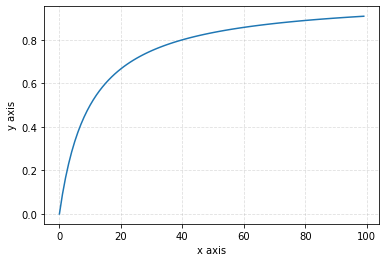

In [6]:
def func(x):
    return 1.0 - (10.0 / (10.0 + x))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.array(range(100))

y = func(x)
plt.plot(x,y)
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.grid(alpha=.4,linestyle='--')
plt.show()

In [7]:
def naming_func_muscles(wsi_path:pathlib.Path):
    path = Path(wsi_path)
    split = path.stem.split('-')
    return f'{split[0]}'[:-1]

def scoring_function_muscle(tissue_percent, combined_factor):
    """
    This favors pink over purple regions (muscle tissue has few nuclei and lots of sarcoplam, which
    is pink in H&E staining). color_factor and s_and_v_factor are higher, 
    the more hematoxylin stained tissue is in the image
    """
    if(combined_factor == 0):
        return tissue_percent / 2
    else:
        return (100/(combined_factor)) * tissue_percent / 100       

In [8]:
### against DecompressionBombWarning
from PIL import Image
Image.MAX_IMAGE_PIXELS = 115990855680000 

tile_score_thresh=0.5
tilesummaries_muscles_path = Path(f'./tilesummaries_muscles_{tile_score_thresh}.pickle')


if os.path.isfile(tilesummaries_muscles_path):
    ###
    # just load from disc, if you have already calculated tile infos before
    ###
    tilesummaries_muscles = load_pickle(tilesummaries_muscles_path)
else:
    ###
    # generate and save tile info
    ###
    tilesummaries_muscles = tiles.WsiOrROIToTilesMultithreaded(wsiPaths = MUSCLES_WSIS.ls(), 
                                                       tilesFolderPath=None, 
                                                       tileWidth=512, 
                                                       tileHeight=512, 
                                                       tile_naming_func = naming_func_muscles, 
                                                       save_tiles=False,
                                                       tileScoringFunction = scoring_function_muscle, 
                                                       is_wsi=True, 
                                                       tile_score_thresh=tile_score_thresh, 
                                                       return_as_tilesummary_object=True)
    #save_as_pickle(tilesummaries_muscles, tilesummaries_muscles_path)

Starting to process /home/Deep_Learner/private/datasets/Muskeln/wsis/DKO474_US_hom_1_HE - 2020-04-07 11.35.13.ndpi
Starting to process /home/Deep_Learner/private/datasets/Muskeln/wsis/DKO474_US_hom_3_HE - 2020-04-07 11.46.24.ndpi
Starting to process /home/Deep_Learner/private/datasets/Muskeln/wsis/DKO474_US_hom_2_HE - 2020-04-07 11.40.20.ndpi
Starting to process /home/Deep_Learner/private/datasets/Muskeln/wsis/DKO476_US_wt_2_HE - 2020-04-07 12.08.00.ndpi
Starting to process /home/Deep_Learner/private/datasets/Muskeln/wsis/DKO476_US_wt_5_HE - 2020-04-07 12.13.27.ndpi
Starting to process /home/Deep_Learner/private/datasets/Muskeln/wsis/DKO476_US_wt_3_HE - 2020-04-07 12.09.33.ndpi
Starting to process /home/Deep_Learner/private/datasets/Muskeln/wsis/DKO476_US_wt_7_HE - 2020-04-07 12.21.42.ndpi
Starting to process /home/Deep_Learner/private/datasets/Muskeln/wsis/DKO476_US_wt_4_HE - 2020-04-07 12.11.11.ndpi
Starting to process /home/Deep_Learner/private/datasets/Muskeln/wsis/DKO482_US_hom_5_

In [ ]:
for ts in tilesummaries_muscles:
    tiles.show_wsi_with_marked_tiles(tilesummary=ts)

### dataset getter

In [9]:
def open_image_from_wsi(dataset_dict,
                        convert_mode:str='RGB')->PIL.Image:
    tile = dataset_dict['tile']
    wsi_path = tile.wsi_path
    x = tile.get_x()
    y = tile.get_y()
    width = tile.get_width()
    height = tile.get_height()
    level = tile.level
    tile = tiles.ExtractTileFromWSI(path=wsi_path, x=x, y=y, width=width, height=height, level=level)
    tile = tile.convert(convert_mode)
    #tile = fastai.vision.image.pil2tensor(tile,np.float32)
    return tile

from fvcore.common.file_io import PathManager
#detectron2.data.detection_utils.read_image
def read_image_custom(dataset_dict, format=None):
    """
    Read an image into the given format.
    Will apply rotation and flipping if the image has such exif information.
    Args:
        dataset_dict: 
        format (str): one of the supported image modes in PIL, or "BGR"
    Returns:
        image (np.ndarray): an HWC image in the given format.
    """
    image = open_image_from_wsi(dataset_dict=dataset_dict)

    # capture and ignore this bug: https://github.com/python-pillow/Pillow/issues/3973
    try:
        image = ImageOps.exif_transpose(image)
    except Exception:
        pass

    if format is not None:
        # PIL only supports RGB, so convert to RGB and flip channels over below
        conversion_format = format
        if format == "BGR":
            conversion_format = "RGB"
        image = image.convert(conversion_format)
    image = np.asarray(image)
    if format == "BGR":
        # flip channels if needed
        image = image[:, :, ::-1]
    # PIL squeezes out the channel dimension for "L", so make it HWC
    if format == "L":
        image = np.expand_dims(image, -1)
    return image

detectron2.data.detection_utils.read_image = read_image_custom



#https://detectron2.readthedocs.io/tutorials/data_loading.html
#https://detectron2.readthedocs.io/_modules/detectron2/data/dataset_mapper.html#DatasetMapper
import copy
import logging
import numpy as np
import torch
from fvcore.common.file_io import PathManager
from PIL import Image

from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T

"""
This file contains the default mapping that's applied to "dataset dicts".
"""

__all__ = ["DatasetMapper"]

### changes to default:
# - in __call__ : read_image_custom 
class DatasetMapper_Custom:
    """
    A callable which takes a dataset dict in Detectron2 Dataset format,
    and map it into a format used by the model.

    This is the default callable to be used to map your dataset dict into training data.
    You may need to follow it to implement your own one for customized logic,
    such as a different way to read or transform images.
    See :doc:`/tutorials/data_loading` for details.

    The callable currently does the following:

    1. Read the image from "file_name"
    2. Applies cropping/geometric transforms to the image and annotations
    3. Prepare data and annotations to Tensor and :class:`Instances`
    """

    def __init__(self, cfg, is_train=True):
        if cfg.INPUT.CROP.ENABLED and is_train:
            self.crop_gen = T.RandomCrop(cfg.INPUT.CROP.TYPE, cfg.INPUT.CROP.SIZE)
            logging.getLogger(__name__).info("CropGen used in training: " + str(self.crop_gen))
        else:
            self.crop_gen = None

        self.tfm_gens = utils.build_transform_gen(cfg, is_train)

        # fmt: off
        self.img_format     = cfg.INPUT.FORMAT
        self.mask_on        = cfg.MODEL.MASK_ON
        self.mask_format    = cfg.INPUT.MASK_FORMAT
        self.keypoint_on    = cfg.MODEL.KEYPOINT_ON
        self.load_proposals = cfg.MODEL.LOAD_PROPOSALS
        # fmt: on
        if self.keypoint_on and is_train:
            # Flip only makes sense in training
            self.keypoint_hflip_indices = utils.create_keypoint_hflip_indices(cfg.DATASETS.TRAIN)
        else:
            self.keypoint_hflip_indices = None

        if self.load_proposals:
            self.min_box_side_len = cfg.MODEL.PROPOSAL_GENERATOR.MIN_SIZE
            self.proposal_topk = (
                cfg.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TRAIN
                if is_train
                else cfg.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TEST
            )
        self.is_train = is_train


    def __call__(self, dataset_dict):
        """
        Args:
            dataset_dict (dict): Metadata of one image, in Detectron2 Dataset format.

        Returns:
            dict: a format that builtin models in detectron2 accept
        """
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        # USER: Write your own image loading if it's not from a file
                
        #image = utils.read_image(dataset_dict["file_name"], format=self.img_format)
        image = read_image_custom(dataset_dict, format=self.img_format)
        
        
        utils.check_image_size(dataset_dict, image)

        if "annotations" not in dataset_dict:
            image, transforms = T.apply_transform_gens(
                ([self.crop_gen] if self.crop_gen else []) + self.tfm_gens, image
            )
        else:
            # Crop around an instance if there are instances in the image.
            # USER: Remove if you don't use cropping
            if self.crop_gen:
                crop_tfm = utils.gen_crop_transform_with_instance(
                    self.crop_gen.get_crop_size(image.shape[:2]),
                    image.shape[:2],
                    np.random.choice(dataset_dict["annotations"]),
                )
                image = crop_tfm.apply_image(image)
            image, transforms = T.apply_transform_gens(self.tfm_gens, image)
            if self.crop_gen:
                transforms = crop_tfm + transforms

        image_shape = image.shape[:2]  # h, w

        # Pytorch's dataloader is efficient on torch.Tensor due to shared-memory,
        # but not efficient on large generic data structures due to the use of pickle & mp.Queue.
        # Therefore it's important to use torch.Tensor.
        dataset_dict["image"] = torch.as_tensor(np.ascontiguousarray(image.transpose(2, 0, 1)))

        # USER: Remove if you don't use pre-computed proposals.
        if self.load_proposals:
            utils.transform_proposals(
                dataset_dict, image_shape, transforms, self.min_box_side_len, self.proposal_topk
            )

        if not self.is_train:
            # USER: Modify this if you want to keep them for some reason.
            dataset_dict.pop("annotations", None)
            dataset_dict.pop("sem_seg_file_name", None)
            return dataset_dict

        if "annotations" in dataset_dict:
            # USER: Modify this if you want to keep them for some reason.
            for anno in dataset_dict["annotations"]:
                if not self.mask_on:
                    anno.pop("segmentation", None)
                if not self.keypoint_on:
                    anno.pop("keypoints", None)

            # USER: Implement additional transformations if you have other types of data
            annos = [
                utils.transform_instance_annotations(
                    obj, transforms, image_shape, keypoint_hflip_indices=self.keypoint_hflip_indices
                )
                for obj in dataset_dict.pop("annotations")
                if obj.get("iscrowd", 0) == 0
            ]
            instances = utils.annotations_to_instances(
                annos, image_shape, mask_format=self.mask_format
            )
            # Create a tight bounding box from masks, useful when image is cropped
            if self.crop_gen and instances.has("gt_masks"):
                instances.gt_boxes = instances.gt_masks.get_bounding_boxes()
            dataset_dict["instances"] = utils.filter_empty_instances(instances)

        # USER: Remove if you don't do semantic/panoptic segmentation.
        if "sem_seg_file_name" in dataset_dict:
            with PathManager.open(dataset_dict.pop("sem_seg_file_name"), "rb") as f:
                sem_seg_gt = Image.open(f)
                sem_seg_gt = np.asarray(sem_seg_gt, dtype="uint8")
            sem_seg_gt = transforms.apply_segmentation(sem_seg_gt)
            sem_seg_gt = torch.as_tensor(sem_seg_gt.astype("long"))
            dataset_dict["sem_seg"] = sem_seg_gt
        return dataset_dict

    
detectron2.data.dataset_mapper = DatasetMapper_Custom

In [10]:
def get_nuclei_dicts_muscles(wsi_paths:List[pathlib.Path], pickle_filepath:pathlib.Path):
    """
    Arguments:
        
    """
    if pickle_filepath != None and pickle_filepath.exists():
        return load_pickle(pickle_filepath)
    else:
        dataset_dicts = []
        n = 0
        for ts in tqdm(tilesummaries_muscles):
            if ts.wsi_path in wsi_paths:
                n += 1
                for tile in ts.top_tiles():
                    record = {}
                    
                    record['tile'] = tile
                    record["file_name"] = tile.get_name()
                    record["image_id"] = tile.get_name()
                    record["height"] = tile.get_height()
                    record["width"] = tile.get_width()
                    
                    #no ground truth masks available               
                    record["annotations"] = []
                    dataset_dicts.append(record)
            
        #save_as_pickle(dataset_dicts, pickle_filepath)
        print(f'Number of WSIs: {n}')
        return dataset_dicts

In [11]:
dataset_dicts_muscles = get_nuclei_dicts_muscles(MUSCLES_WSIS.ls(), None)

/home/Deep_Learner/private/datasets/Muskeln/wsis/DKO476_US_wt_7_HE - 2020-04-07 12.21.42.ndpi: Number of tiles that will be kept/all possible tiles: 232/1120
/home/Deep_Learner/private/datasets/Muskeln/wsis/DKO488_US_wt_12_HE - 2020-04-07 12.06.24.ndpi: Number of tiles that will be kept/all possible tiles: 198/1120
/home/Deep_Learner/private/datasets/Muskeln/wsis/DKO488_US_wt_9_HE - 2020-04-07 12.03.11.ndpi: Number of tiles that will be kept/all possible tiles: 252/1344
/home/Deep_Learner/private/datasets/Muskeln/wsis/DKO476_US_wt_3_HE - 2020-04-07 12.09.33.ndpi: Number of tiles that will be kept/all possible tiles: 232/1120
/home/Deep_Learner/private/datasets/Muskeln/wsis/DKO482_US_hom_8_HE - 2020-04-07 11.31.56.ndpi: Number of tiles that will be kept/all possible tiles: 321/2058
/home/Deep_Learner/private/datasets/Muskeln/wsis/DKO482_US_hom_9_HE - 2020-04-07 11.33.28.ndpi: Number of tiles that will be kept/all possible tiles: 328/2058
/home/Deep_Learner/private/datasets/Muskeln/wsis/

### register dataset

In [12]:
DatasetCatalog.clear()
DatasetCatalog.register(dataset_name_muscle, lambda : get_nuclei_dicts_muscles(MUSCLES_WSIS.ls(), None))
MetadataCatalog.get(dataset_name_muscle).set(thing_classes=["nucleus"])
cfg.DATASETS.TEST = (dataset_name_muscle, )

###  load metadata

In [13]:
metadata_nuclei_muscle = MetadataCatalog.get(dataset_name_muscle)

### predictions

In [15]:
predictor = DefaultPredictor(cfg)

In [14]:
def extract_wsi_name_from_tile_name_muscles(tile_name):
    splits = tile_name.split('_')
    wsi_name = ''
    for i in range(4):
        wsi_name += f'{splits[i]}_'
    return wsi_name+'HE'

In [15]:
extract_wsi_name_from_tile_name_muscles(dataset_dicts_muscles[0]['file_name'])

'DKO476_US_wt_7_HE'

In [16]:
###
# all preds saved to one file (gets pretty big)
###
#dataset_dicts_muscles_with_preds_dir = Path('./dataset_dicts/with_preds')
#
#if dataset_dicts_muscles_with_preds_pickle_filepath.exists():
#    dataset_dicts_muscles = load_pickle(dataset_dicts_muscles_with_preds_pickle_filepath)
#
#else:
#    for d in tqdm(dataset_dicts_muscles[:]):
#        img_pil_rgb = open_image_from_wsi(d)
#        img_np_bgr = np.array(img_pil_rgb)[:,:,::-1]
#        with torch.no_grad():
#            pred = predictor(img_np_bgr)
#            pred['instances'] = pred['instances'].to('cpu')
#        d['prediction'] = pred
#        del pred
#        torch.cuda.empty_cache()
#    save_as_pickle(dataset_dicts_muscles, dataset_dicts_muscles_with_preds_pickle_filepath)


###
# saved file for every wsi
###
dataset_dicts_muscles_with_preds_dir = Path('./dataset_dicts/with_preds/')
for ts in tqdm(tilesummaries_muscles):
    dds_pickle_path = dataset_dicts_muscles_with_preds_dir/f'{ts.wsi_path.stem}.pickle'
    if not dds_pickle_path.exists():
        print(f'predicting tiles of: {ts.wsi_path.name}')
        dds = [d for d in dataset_dicts_muscles if d['tile'].wsi_path == ts.wsi_path]
        for d in dds:
            img_pil_rgb = open_image_from_wsi(d)
            img_np_bgr = np.array(img_pil_rgb)[:,:,::-1]
            with torch.no_grad():
                pred = predictor(img_np_bgr)
                pred['instances'] = pred['instances'].to('cpu')
            d['prediction'] = pred
            del pred
            torch.cuda.empty_cache()
        save_as_pickle(dds, dds_pickle_path)

### Calculate some nucleus stats

In [76]:
###
# functions per tile
###
def get_number_of_predicted_instances_one_tile(dataset_dict:Dict)->int:
    """
    returns None, if no prediction exists
    """
    if 'prediction' not in dataset_dict.keys():
        #print('This tile has no prediction yet')
        return None
    return len(dataset_dict['prediction']['instances'])
   
def get_combined_nucleus_area_one_tile(dataset_dict:Dict)->float:
    """
    result in um²  based on the predictions
    returns None, if no prediction exists
    """
    if 'prediction' not in dataset_dict.keys():
        #print('This tile has no prediction yet')
        return None
    n_mask_pixels = dataset_dict['prediction']['instances'].get('pred_masks').int().sum().item()
    return n_mask_pixels*slide.get_conversion_factor(dataset_dict['tile'].wsi_path, dataset_dict['tile'].level)**2

def get_average_nucleus_area_one_tile(dataset_dict:Dict)->float:
    """
    calculates the mean nucleus size of one tile in um² based on the predictions
    returns 0, if there is no nucleus instance in the prediction
    returns None, if no prediction exists
    Arguments:
        dataset_dict: dataset_dict with prediction of one tile
    Result:
        mean nucleus size in um² 
        None if  - no prediction at the key 'prediction'
                 - no nucleus in the prediction
    """
    if 'prediction' not in dataset_dict.keys():
        #print('This tile has no prediction yet')
        return None
    return 0 if get_number_of_predicted_instances_one_tile(dataset_dict) == 0 else \
        (get_combined_nucleus_area_one_tile(dataset_dict)/get_number_of_predicted_instances_one_tile(dataset_dict))\
        .item()

def get_masks_one_tile(dataset_dict:Dict)->torch.tensor:
    """
    return tensor of shape (n_masks, mask_height, mask_width) for all nuclei in the tile
    returns None, if there are no masks
    """
    if len(dataset_dict['prediction']['instances']) == 0:
        return None
    return dataset_dict['prediction']['instances'].get('pred_masks')


class Wsi:
    tilesummary: tiles.TileSummary = None
    dataset_dicts_pickle_path = None
    combined_nucleus_area: float = None
    average_nucleus_area: float = None
    standard_deviation_nucleus_area: float = None
    variance_nucleus_area: float = None
    
    def __init__(self, tilesummary, dataset_dicts_pickle_path):
        self.tilesummary = tilesummary
        self.dataset_dicts_pickle_path = dataset_dicts_pickle_path
    
    def __str__(self):
        return str(self.tilesummary.wsi_path)
    
    def free_memory(self):
        del self.combined_nucleus_area
        del self.average_nucleus_area
        del self.standard_deviation_nucleus_area
        del self.variance_nucleus_area
    
    def get_conversion_factor(self):
        return slide.get_conversion_factor(self.tilesummary.wsi_path, self.tilesummary.level)
    
    def get_masks(self)->torch.tensor:
        """
        return tensor of shape (n_masks, mask_height, mask_width) for all nuclei in the wsi 
        """
        res = None
        for d in load_pickle(self.dataset_dicts_pickle_path):
            if get_masks_one_tile(d) == None:
                continue
            elif res == None:
                res = get_masks_one_tile(d)
            else:
                res = torch.cat([res, get_masks_one_tile(d)])
        return res
        
    def get_number_of_predicted_instances(self)->int:
        """
        returns the number of predicted instances of the whole-slide image based on the predictions 
        by summing up all predicted instances of all tiles, where predictions exist
        tiles with no existing predictions will be ignored silently
        """
        return sum([get_number_of_predicted_instances_one_tile(d) for d in load_pickle(self.dataset_dicts_pickle_path) if \
                    get_number_of_predicted_instances_one_tile(d) != None])
    
    def get_combined_nucleus_area(self)->float:
        """
        calculates the combined nucleus size of all tiles from one wsi in um² based on the predictions.
        tiles with no predictions will be ignored
        Arguments:
            dataset_dicts: list of all dataset_dicts of the tiles of one whole-slide image
        Result:
            combined nucleus size in um²
        """
        if self.combined_nucleus_area == None:
            if len(load_pickle(self.dataset_dicts_pickle_path)) == 0:
                return None
            self.combined_nucleus_area = self.get_masks().int().sum()*self.get_conversion_factor()**2
        return self.combined_nucleus_area
        
    def get_average_nucleus_area(self)->float:
        """
        calculates the mean nucleus size from the predictions of all tiles from one wsi in um² based on the predictions
        tiles with no predictions will be ignored
        Arguments:
            dataset_dicts: list of all dataset_dicts of the tiles of one whole-slide image
        Result:
            mean nucleus size in um²
        """
        if self.average_nucleus_area == None:
            area = self.get_combined_nucleus_area()
            n = self.get_number_of_predicted_instances()
            self.average_nucleus_area = (area/n).item()
        return self.average_nucleus_area
    
    def get_nucleus_area_variance(self)->float:
        if self.variance_nucleus_area == None:
            self.variance_nucleus_area = np.array(self.get_masks()).sum(axis=(1,2)).var()\
                                            *self.get_conversion_factor()**4
        return self.variance_nucleus_area
    
    def get_nucleus_area_standard_deviation(self)->float:
        if self.standard_deviation_nucleus_area == None:
            self.standard_deviation_nucleus_area = np.array(self.get_masks()).sum(axis=(1,2)).std()\
                                                    *self.get_conversion_factor()**2
        return self.standard_deviation_nucleus_area
        
       
class WsiList:
    name = None
    wsi_list: List[Wsi] = []
    combined_nucleus_area = None
    nuclei_areas_numpy = None
    average_nucleus_area = None
    standard_deviation_nucleus_area = None
    variance_nucleus_area = None
    
    def __init__(self, name:str, wsi_list:List[Wsi]):
        self.name = name
        self.wsi_list = wsi_list
        
    def free_memory(self):
        del self.combined_nucleus_area
        del self.nuclei_areas_numpy
        #del self.average_nucleus_area
        del self.standard_deviation_nucleus_area
        del self.variance_nucleus_area
    
    def add_wsi(self, wsi:Wsi):
        self.wsi_list.append(wsi)
        
    def get_masks(self)->torch.tensor:
        """
        return tensor of shape (n_masks, mask_height, mask_width) for all nuclei in the wsi
        watch out! the masks could be from wsis with different levels of zoom
        """
        res = None
        for w in self.wsi_list:
            if res is None:
                res = w.get_masks()
            else:
                res = torch.cat([res, w.get_masks()])
        return res    
    
    def get_number_of_predicted_instances(self):
        return sum([wsi.get_number_of_predicted_instances() for wsi in self.wsi_list])
    
    def get_combined_nucleus_area(self):
        if self.combined_nucleus_area is None:
            self.combined_nucleus_area = sum([wsi.get_combined_nucleus_area() for wsi in self.wsi_list])
        return self.combined_nucleus_area
    
    def get_average_nucleus_area(self):
        return self.get_combined_nucleus_area()/self.get_number_of_predicted_instances()
    
    def get_nuclei_areas(self):
        """
        returns numpy array of shape (number_of_nuclei, nucleus_area_um²)
        different zoom levels of the wsis get taken into account
        """
        if self.nuclei_areas_numpy is None:
            nuclei_areas = None
            for w in self.wsi_list:
                nas_w = np.array(w.get_masks()).sum(axis=(1,2))*w.get_conversion_factor()**2 
                if nuclei_areas is None:
                    nuclei_areas = nas_w
                else: 
                    nuclei_areas = np.concatenate((nuclei_areas, nas_w))
            self.nuclei_areas_numpy = nuclei_areas
        return self.nuclei_areas_numpy
    
    def get_nucleus_area_variance(self)->float:
        if self.variance_nucleus_area is None:
            self.variance_nucleus_area = self.get_nuclei_areas().var()
        return self.variance_nucleus_area
            
    
    def get_nucleus_area_standard_deviation(self)->float:
        if self.standard_deviation_nucleus_area == None:
            self.standard_deviation_nucleus_area = self.get_nuclei_areas().std()
        return self.standard_deviation_nucleus_area
    
    def plot_area_distribution_histogram(self):
        data = []
        for wsi in self.wsi_list:
            for d in load_pickle(wsi.dataset_dicts_pickle_path):
                for m in d['prediction']['instances'].get('pred_masks'):
                    data.append(m.int().sum()*slide.get_conversion_factor(d['tile'].wsi_path, d['tile'].level)**2)
            wsi.free_memory()
        bins = np.linspace(0, max(data), 200)
        plt.hist(probs_true_positive, bins, alpha=1.0, label=None)
        plt.legend(loc='upper right')
        plt.title(label=name)
        plt.ylabel('Frequency')
        plt.xlabel('area in um²')
        plt.show()

In [77]:
### init two WsiList objects

wsi_list_hom = WsiList('hom', [])
wsi_list_wt = WsiList('wt', [])

for ts in tilesummaries_muscles:
    dds = [d for d in dataset_dicts_muscles if d['tile'].wsi_path == ts.wsi_path]
    if 'hom' in ts.wsi_path.name:
        wsi_list_hom.add_wsi(Wsi(ts, dataset_dicts_muscles_with_preds_dir/f'{ts.wsi_path.stem}.pickle'))
    elif 'wt' in ts.wsi_path.name:
        wsi_list_wt.add_wsi(Wsi(ts, dataset_dicts_muscles_with_preds_dir/f'{ts.wsi_path.stem}.pickle'))
    else:
        assert False

In [56]:
### function that shall be run in parallel
def create_df_nuclei_stats_muscles_single_wsis(wsi):
    df = pd.DataFrame(columns=['wsi name', 'nuclei', 'avg nucleus area um²', 'standard deviation', 'variance'])
    name = wsi.tilesummary.wsi_path.stem
    n = wsi.get_number_of_predicted_instances()
    avg_area = wsi.get_average_nucleus_area()
    sd = wsi.get_nucleus_area_standard_deviation()
    var = wsi.get_nucleus_area_variance()
    df = df.append({'wsi name':name, 
                    'nuclei':n, 
                    'avg nucleus area um²':avg_area,
                    'standard deviation':sd, 
                    'variance':var}, 
                    ignore_index=True)
    wsi.free_memory()
    return df


###sequential execution
results = []
for wsi in tqdm(wsi_list_wt.wsi_list+wsi_list_hom.wsi_list):
    results.append(create_df_nuclei_stats_muscles_single_wsis(wsi))




###multithread execution
#pbar = tqdm(total=len(wsi_list_wt.wsi_list+wsi_list_hom.wsi_list))
#results = []
#def update(res):
#    results.append(res)
#    pbar.update()
#     
#with multiprocessing.Pool(processes=4) as pool:
#    for wsi in wsi_list_wt.wsi_list+wsi_list_hom.wsi_list:
#        pool.apply_async(create_df_nuclei_stats_muscles_single_wsis, 
#                         args=(wsi), 
#                               callback=update)
#        
#            
#    pool.close()
#    pool.join()

### merge results into one dataframe
merged_df = None
for res in tqdm(results):
    if merged_df is None:
        merged_df = res
    else:
        merged_df = merged_df.append(res, sort=False)

### save end result to disk
df_nuclei_stats_muscles_single_wsis = merged_df.drop_duplicates(inplace=False)
df_nuclei_stats_muscles_single_wsis.to_csv(Path('./single_wsi_stats.csv'))

In [68]:
df_nuclei_stats_muscles_single_wsis

,wsi name,nuclei,avg nucleus area um²,standard deviation,variance
0,DKO476_US_wt_7_HE - 2020-04-07 12.21.42,2423,22.903921,24.126084,582.067933
0,DKO488_US_wt_12_HE - 2020-04-07 12.06.24,1983,23.685217,29.154208,849.967824
0,DKO488_US_wt_9_HE - 2020-04-07 12.03.11,2742,21.556290,21.622521,467.533401
0,DKO476_US_wt_3_HE - 2020-04-07 12.09.33,2235,21.922083,20.310072,412.499044
0,DKO476_US_wt_4_HE - 2020-04-07 12.11.11,641,33.826317,42.324942,1791.400695
0,DKO488_US_wt_7_HE - 2020-04-07 11.59.21,2341,24.981358,27.398928,750.701241
0,DKO488_US_wt_8_HE - 2020-04-07 12.01.37,1702,26.889074,29.099665,846.790518
0,DKO488_US_wt_10_HE - 2020-04-07 12.04.51,2765,21.932411,22.059789,486.634309
0,DKO476_US_wt_2_HE - 2020-04-07 12.08.00,985,25.354111,31.267081,977.630380
0,DKO476_US_wt_5_HE - 2020-04-07 12.13.27,2040,24.459785,27.770803,771.217487


In [ ]:
### function that shall be run in parallel
def create_df_nuclei_stats_muscles_wsi_lists(wsi_list):
    df = pd.DataFrame(columns=['list name', 'nuclei', 'avg nucleus area um²', 'standard deviation', 'variance'])
    name = wsi_list.name
    n = wsi_list.get_number_of_predicted_instances()
    avg_area = wsi_list.get_average_nucleus_area()
    sd = wsi_list.get_nucleus_area_standard_deviation()
    var = wsi_list.get_nucleus_area_variance()
    df = df.append({'list name':name, 
                    'nuclei':n, 
                    'avg nucleus area um²':avg_area,
                    'standard deviation':sd, 
                    'variance':var}, 
                    ignore_index=True)
    wsi_list.free_memory()
    return df


###sequential execution
results = []
for wsi_list in tqdm([wsi_list_wt, wsi_list_hom]):
    results.append(create_df_nuclei_stats_muscles_wsi_lists(wsi_list))


###multithread execution
#pbar = tqdm(total=len(wsi_list_wt.wsi_list+wsi_list_hom.wsi_list))
#results = []
#def update(res):
#    results.append(res)
#    pbar.update()
#     
#with multiprocessing.Pool(4) as pool:
#    for wsi_list in [wsi_list_wt, wsi_list_hom]:
#        pool.apply_async(create_df_nuclei_stats_muscles_wsi_lists, 
#                         args=(wsi_list), 
#                               callback=update)
#        
#            
#    pool.close()
#    pool.join()

### merge results into one dataframe
merged_df = None
for res in tqdm(results):
    if merged_df is None:
        merged_df = res
    else:
        merged_df = merged_df.append(res, sort=False)
        
df_nuclei_stats_muscles_wsi_lists = merged_df
df_nuclei_stats_muscles_wsi_lists.to_csv(Path('./wsi_lists_stats.csv'))

In [ ]:
wsi_list_hom.plot_area_distribution_histogram()

In [ ]:
wsi_list_wt.plot_area_distribution_histogram()

In [ ]:
visualize(dataset_dicts=dataset_dicts_muscles[1:20], 
          metadata=metadata_nuclei_muscle,
          ground_truth_available=False,
          with_preds=True,
          predictor=predictor, 
          extract_otf_from_wsi=True,  
          captions=None, 
          figsize=(10,10),
          caption_generators=[get_combined_nucleus_area_one_tile, get_average_nucleus_area_one_tile])

# keep for later use

In [ ]:
#DKO474_US_hom_1_HE - 2020-04-07 11.35.13.ndpi
# meassured by hand in case viewer app
##width in um
22916.1

##height in um
9482.5